# Diagnostics to Improve Models in the Titanic Kaggle Competition

[Douglas Friesen, PhD](https://www.linkedin.com/in/douglas-friesen-phd/), April 2021

The sinking of the Titanic, which happened on April 15, 1912, is one of the most famous shipwrecks in history. It forms the basis of the introductory [machine learning competition](https://www.kaggle.com/c/titanic) on Kaggle. The basis of this competition is the binary classification problem: Given features of the passengers on the Titanic, predict whether or not they survived when the Titanic sunk.

In this notebook, I go through the process of designing an optimal model to predict survival:
* Understanding of Problem
* Exploration of Data
* Cleaning of Data
* Feature Engineering
* Model Selection
* Hyperparameter optimization for models
* Model Testing

I supplement these common elements of machine learning problems in Kaggle competitions with a focus on the following:
1. Evaluating the model predictions using Confusion Matrices, ROC curves, and Area under the curve (AUC) scores. This allows insight into modifying the threshold of a binary classifier in order to reduce false positives or false negatives (Type I and Type II error), which is applicable to many binary classification problems, such as those in healthcare.
2. Diagnostics to point to the most efficient way to improve predictions, based on evidence of bias or variability in the models. Having models overfit and underfit data are common problems, and being able to diagnose which problem a model has can lead to pursuing efforts that improve a model.

The motivation of this guide is to explore the suggestions made by Andrew Ng in his Stanford class CS229 lecture entitled: [Lecture 13 - Debugging ML Models and Error Analysis | Stanford CS229: Machine Learning (Autumn 2018)](https://www.youtube.com/watch?v=ORrStCArmP4). The main question explored in this lecture is that after a model has been created, what is the most efficient use of time to improve the model? There are many ways to improve an algorithm, and figuring out the best way involves diagnostics to understand what the main problem the model is encountering. Common problems are:
* High bias
* High variance
* Problem with the optimization algorithm
* Problem with the optimization objective

Professor Ng indicates a strong understanding of these elements can save months in a tough data science problem by targeting what will actually improve performance in an underperforming model.

As well, the lecture explores error analysis and ablative analysis when multiple learning components form a pipeline, to understand which part of the pipeline is key to the algorithm's success, and which parts have the most potential to improve the algorithm. We will perform ablative analysis on our features in classifying survival in this project as a step to identifying ways to improve the model developed.

This notebook takes elements from other Kaggle notebooks in the setup of the features and the models.

### Titanic Kaggle Competition

#### Step 1. Undestanding of Problem

The problem is a straight-forward [binary classification challenge](https://www.kaggle.com/c/titanic), to predict who survives the Titanic shipwreck. Passenger information is given on all passengers. Further understanding of the problem will be developed as we explore the data.

#### Step 2. Exploration of Data

##### 2.1: Acquire Data and store in Pandas DataFrame

The training set and test set are given to us in separate csv files.


In [428]:
import numpy as np
import pandas as pd

train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

##### 2.2: Exploration of Data

Here we'll look at the data given to us on each passenger. We'll look at the first 5 and last 5 entries in the training set.

In [429]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.283,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.100,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.050,NaN,S


In [430]:
train.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


There are 891 passengers, with 12 fields per passenger:

In [431]:
train.shape

(891, 12)

Data Types:

In [432]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


There's a mixture of numeric and non-numeric types. Let's get stats on the numeric fields:

In [433]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000,257.354,1.00,223.500,446.000,668.5,891.000
Survived,891.0,0.384,0.487,0.00,0.000,0.000,1.0,1.000
Pclass,891.0,2.309,0.836,1.00,2.000,3.000,3.0,3.000
Age,714.0,29.699,14.526,0.42,20.125,28.000,38.0,80.000
SibSp,891.0,0.523,1.103,0.00,0.000,0.000,1.0,8.000
Parch,891.0,0.382,0.806,0.00,0.000,0.000,0.0,6.000
Fare,891.0,32.204,49.693,0.00,7.910,14.454,31.0,512.329


Also, let's see how many passengers are in the test set:

In [434]:
test.shape

(418, 11)

The above exploration gives an overview of the data. To get a complete picture of the data, the type of information should be inspected for all the 891 passengers in the training set and 418 passengers in the test set. The full description of the fields is found on the [Kaggle Titanic Data page](https://www.kaggle.com/c/titanic/data).

In terms of getting a better idea of which fields are most useful, we'll inspect the correlation matrix to see what's correlated with `Survived` in the training set.

In [435]:
train.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000,-0.005,-0.035,0.037,-0.058,-0.002,0.013
Survived,-0.005,1.000,-0.338,-0.077,-0.035,0.082,0.257
Pclass,-0.035,-0.338,1.000,-0.369,0.083,0.018,-0.549
Age,0.037,-0.077,-0.369,1.000,-0.308,-0.189,0.096
SibSp,-0.058,-0.035,0.083,-0.308,1.000,0.415,0.160
Parch,-0.002,0.082,0.018,-0.189,0.415,1.000,0.216
Fare,0.013,0.257,-0.549,0.096,0.160,0.216,1.000


Looks like Pclass and Fare are most correlated with survival in this preliminary analysis. This makes sense, as Pclass is a proxy of socio-econic status (1 = Upper; 2 = Middle; 3 = Lower). Fare also would be linked to class, as we'd assume first class tickets would cost more.

This matrix includes only numeric fields, and thus leaves out important information like the gender of the passenger.

Now, let's check if there is any data missing in the fields:

In [436]:
train.isna().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool

There's data missing in the `Age`, `Cabin`, and `Embarked` fields, so we'll have to do data cleaning. Let's see how much data is missing for each field:


In [437]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

`Age` and `Cabin` have a lot of missing data, while `Embarked` only has a few missing entries.
To fix the data, we'll want to fix both the training set and the test set at the same time. So we'll merge the data into one DataFrame: `df`.

In [438]:
train_size = train.shape[0]
df = pd.concat([train, test], axis=0)

Let's inspect `df` and check for missing data:

In [439]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.250,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.283,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.100,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.050,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.050,NaN,S
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.900,C105,C
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.250,NaN,S
416,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.050,NaN,S


In [440]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


In [441]:
df.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

So we'll want to fill in the missing null values in four fields: `Age`, `Fare`, `Cabin`, and `Embarked`. The null values in the `Survived` field are from the test set.

Now let's analyse the columns to gain insight from them. We'll start with the "Sex" Column, as it likely has good predictive information on whether the passenger survived. We'll make the new feature: `Female` as binary 1 and 0 to make it easier for classitication models.

In [442]:
df.groupby('Sex').nunique()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
Sex,,,,,,,,,,,
female,466,2,3,465,70,7,8,345,189,103,3
male,843,2,3,842,96,7,8,739,236,132,3


So `Sex` is made up entirely of 'male' and 'female' entries, so let's make our first new feature, `Female`:

In [443]:
df['Female'] = (df['Sex'] == 'female').astype(int)

We can check that the feature was added correctly with 1309 non-null entries:

In [444]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
 12  Female       1309 non-null   int32  
dtypes: float64(3), int32(1), int64(4), object(5)
memory usage: 138.1+ KB


In [445]:
train = df[0:train_size]

Of the training set, let's see what percentage of women survived. We recall that in the Titanic sinking, "women and children" should have had the highest chance of survival.

In [446]:
train[['Female','Survived']].groupby(['Female']).mean()

,Survived
Female,
0,0.189
1,0.742


Indeed, women had a 74% chance of surviving, vs. 19% for men, in the training set. So gender looks definitely to be an excellent predictor of survival. Let's start graphing these insights.

In [447]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

Text(0.5, 1.0, 'Survival Rate for Men and Women')

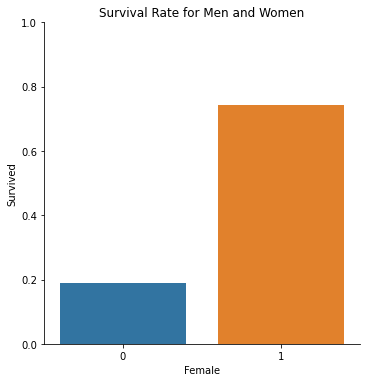

In [520]:
g =sns.catplot(x="Female", y="Survived", data=train, kind="bar", ci=None)
g.set(ylim=(0, 1))
plt.title("Survival Rate for Men and Women")

Now let's investigate `Pclass`. What did a person's class indicate in terms of survival in the training set?

In [449]:
train[['Pclass','Survived']].groupby(['Pclass']).mean()

,Survived
Pclass,
1,0.630
2,0.473
3,0.242


Text(0.5, 1.0, 'Survival Rate for First, Second, and Third Class Passengers')

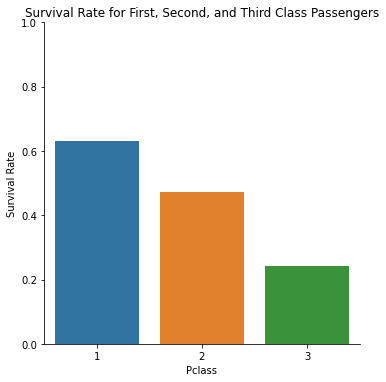

In [521]:
g = sns.catplot(x="Pclass", y="Survived", data=train, kind="bar", ci=None)
g.set_axis_labels("Pclass", "Survival Rate").set(ylim=(0, 1))
plt.title("Survival Rate for First, Second, and Third Class Passengers")

From this, class is an excellent predictor of survival as well. A first class passenger was 2.6x as likely to survive in the training set.

Put Together, graphing survival for men and women in the three classes:
    

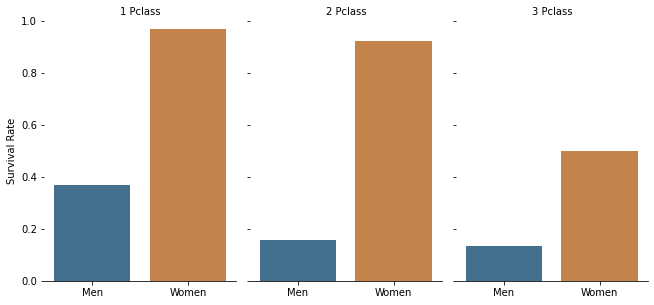

In [451]:
g = sns.catplot(x="Sex", y="Survived", col="Pclass",
                    data=train, saturation=.5,
                    kind="bar", ci=None, aspect=.6)
(g.set_axis_labels("", "Survival Rate")
    .set_xticklabels(["Men", "Women"])
    .set_titles("{col_name} {col_var}")
    .set(ylim=(0, 1))
    .despine(left=True))  
plt.subplots_adjust(top=0.8)

This shows first and second class women were very likely to survive. Men in first class were much more likely to survive than men in second and third class.

Next look at age:

In [452]:
df['Age'].describe()

count    1046.000
mean       29.881
std        14.413
min         0.170
25%        21.000
50%        28.000
75%        39.000
max        80.000
Name: Age, dtype: float64

So ages ranged from 0 to 80.

Text(0, 0.5, 'Count')

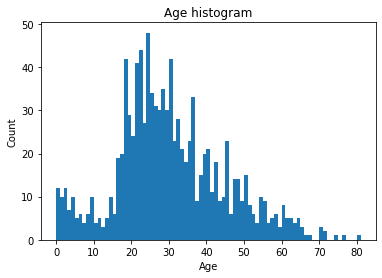

In [453]:
plt.hist([df['Age']], bins=81, range=(0,81))
plt.title("Age histogram")
plt.xlabel("Age")
plt.ylabel("Count")

Let's look at the ages of men and women who survived and those that didn't in the training set:

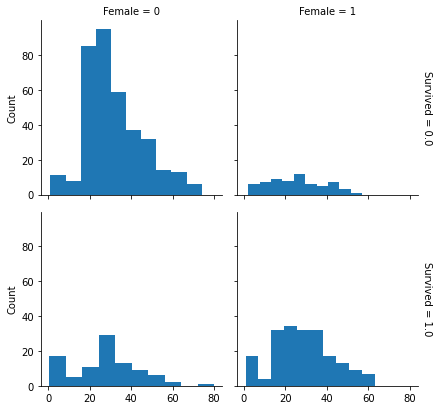

In [454]:
g = sns.FacetGrid(train, col="Female", row="Survived", margin_titles=True)
g = g.map(plt.hist, "Age")
g.set_axis_labels("", "Count")

There's not a lot that stands out here on the surface for age indicating survival probability.

Now let's look at the location where passengers embarked as it relates to those who survived (bars in lower graph are standard deviation). S = Southampton, C = Cherbourg, Q = Queenstown. 

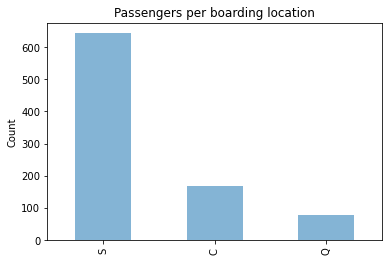

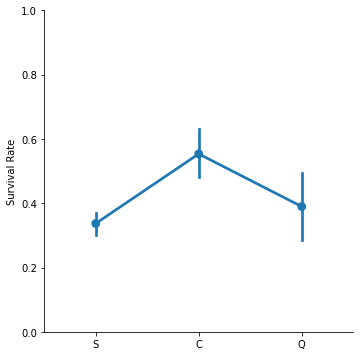

In [455]:
train.Embarked.value_counts().plot(kind='bar', alpha=0.55)
plt.title("Passengers per boarding location")
plt.ylabel("Count")

g = sns.catplot(x = 'Embarked',y="Survived", data = train,kind='point')

g.set(ylim=(0, 1))
g.set_axis_labels("", "Survival Rate")

S = Southampton, C = Cherbourg, Q = Queenstown. 
There isn't too much info here it appears. People from Cherbourg seemed to survive the most. How this relates to class could be explored more, to see if there is additional survival information from this feature. 

Now we'll process people's names, which are in a format for each person that gives their title. Title's are, for example, "Mr.", "Mrs", "Miss", etc.

We'll put titles in categories, as there are a lot of special titles that only a few people have, like "Capt" and "Countess". The "Special" title category includes all these special titles.

In [456]:
# Start on getting info from people's names
# Strip quotes out of people's names
df['NameFixed'] = df['Name'].str.replace('\"','').str.strip()

In [457]:
df.iloc[875].Name

'Najib, Miss. Adele Kiamie "Jane"'

In [458]:
df.iloc[875].NameFixed

'Najib, Miss. Adele Kiamie Jane'

In [459]:
titlemap = {'Mr': 1, 'Don': 2, 'Dona': 2, 'Jonkheer': 2, 'Capt' :2, 'Col': 2, 'Major': 2, 'Countess': 2,  
            'Rev': 2, 'Sir': 2, 'Lady': 2, 'Dr': 3,  'Master': 4, 'Mme': 5, 'Miss': 5,'Mrs': 6, 'Mlle': 7, 'Ms': 8 }

#titleLabels = {1: 'Mr', 2: 'Special', 3: 'Dr', 4: 'Master', 5: 'Mme/Miss', 6: 'Mrs', 7: 'Mlle', 8:'Ms' }
titleLabels = ['Mr', 'Special', 'Dr', 'Master', 'Mme/Miss', 'Mrs', 'Mlle', 'Ms']
df['Title'] = df['NameFixed'].str.extract('([A-Za-z]+)\.', expand=False)
df['TitleCat'] = df['Title'].map(titlemap)

Here is the number of people in each title category:

Text(0.5, 1.0, 'Passengers per Title Category')

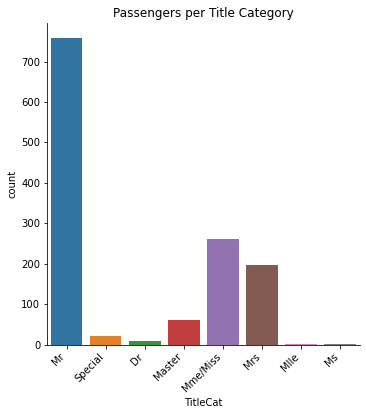

In [460]:
g = sns.catplot(x="TitleCat",data=df, kind="count", ci=None)
g.set_xticklabels(titleLabels, rotation=45, horizontalalignment='right')
plt.title("Passengers per Title Category")

'Mr.' is by far the most common title.

For now, we'll just fill in missing `Age` values with the median age of the `Title` that person is in. A more refined way to do this would be fill in the age as a model prediction, for example from a random forest based on other columns.

In [461]:
for atitle in ['Miss','Mr', 'Mrs', 'Master', 'Dr', 'Ms']:    
    df.loc[ (df['Age'].isnull()) & (df['Title'] == atitle), 'Age'] = df[ (df['Title'] == atitle) ]['Age'].median()

Let's check that all the `Age` values are now filled in (not null):

In [462]:
df.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
Female            0
NameFixed         0
Title             0
TitleCat          0
dtype: int64

Next, let's fill in the rest of the null values. Inspect the one record with a missing fare:

In [463]:
df.loc[df.Fare.isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Female,NameFixed,Title,TitleCat
152,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,0,"Storey, Mr. Thomas",Mr,1


Fill in this fare with the median fare of their class (Third class)

In [464]:
df.loc[df.Fare.isnull(), 'Fare'] = df[ df.Pclass==3].Fare.median()

In [465]:
df.loc[df.PassengerId==1044]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Female,NameFixed,Title,TitleCat
152,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,8.05,NaN,S,0,"Storey, Mr. Thomas",Mr,1


There's a lot of missing fields for the `Cabin` field. Let's make a new feature called `Deck` that extracts the deck from the cabin, and we'll make a new "deck" for all the people that we don't have the cabin they were in.

In [466]:
df["Deck"]=df.Cabin.str[0]

In [467]:
df["Deck"].unique()

array([nan, 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

Let's check out if deck shows any information on whether people survived or not:

Text(0.5, 0.98, 'Number of Passengers that survived per Deck')

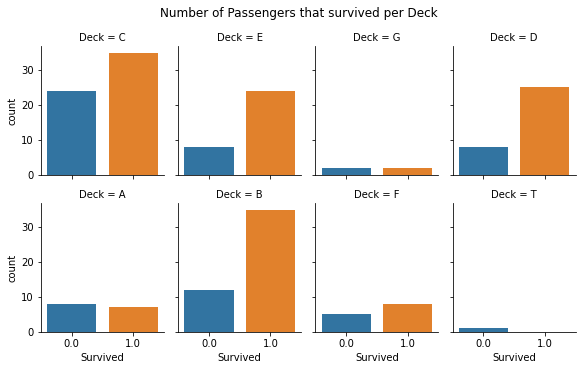

In [468]:
g = sns.catplot(x="Survived", col="Deck", col_wrap=4,
                    data=df[df.Deck.notnull() & df.Survived.notnull()],
                    kind="count", height=2.5, aspect=.8)
g.fig.subplots_adjust(top=0.87)
g.fig.suptitle("Number of Passengers that survived per Deck")

People on decks: B, C, E, and D seem to have done much better than others. We'll make deck `Z` for those without deck information (ie. `Cabin` was null in the data):

In [469]:
df.Deck.fillna('Z', inplace=True)

There's two people with `Embarked` not filled in. Let's see if we can guess the values:

In [470]:
df[df['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Female,NameFixed,Title,TitleCat,Deck
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,1,"Icard, Miss. Amelie",Miss,5,B
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,1,"Stone, Mrs. George Nelson (Martha Evelyn)",Mrs,6,B


Since they are first class women who survived, we'll just say they embarked at Cherbourg, which had the highest probability of survival.

In [471]:
df["Embarked"] = df["Embarked"].fillna('C')

We'll make `EmbarkedCat` to be a numeric field, for easier processing for models.

In [472]:
embarkedmap = {'S':0, 'Q':1, 'C': 2}
df['EmbarkedCat'] = df['Embarked'].map(embarkedmap)

We now have filled in non-null values everywhere (other than the test set which doesn't have the `Survived` value, and the `Cabin` field which we will drop, since we put information from the `Cabin` into the `Deck` feature):

In [473]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1309 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1309 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1309 non-null   object 
 12  Female       1309 non-null   int32  
 13  NameFixed    1309 non-null   object 
 14  Title        1309 non-null   object 
 15  TitleCat     1309 non-null   int64  
 16  Deck         1309 non-null   object 
 17  EmbarkedCat  1309 non-null   int64  
dtypes: float64(3), int32(1), int64(6), object(8)
memo

We've sorted people's title value in ascending order of survival probability.

Text(0.5, 0.98, 'Survival Rate for each Title Category')

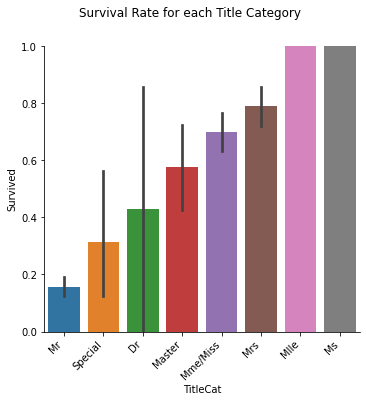

In [474]:
g = sns.catplot(x="TitleCat", y="Survived", data=df[df.Survived.notnull()], kind="bar")
g.set(ylim=(0, 1))
g.set_xticklabels(titleLabels, rotation=45, horizontalalignment='right')
g.fig.subplots_adjust(top=0.87)
g.fig.suptitle("Survival Rate for each Title Category")

We make a `DeckCat` feature that is numeric, in order of survival probability:

Text(0.5, 0.98, 'Survival Rate for each Deck Category')

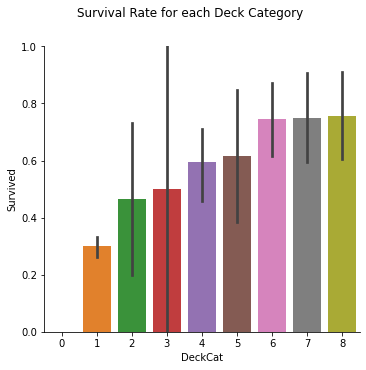

In [475]:
deckmap = {'T': 0, 'Z': 1, 'A': 2, 'G': 3, 'C': 4, 'F': 5, 'B' :6, 'E': 7, 'D': 8}
df['DeckCat'] = df['Deck'].map(deckmap)

g = sns.catplot(x="DeckCat", y="Survived", data=df[df.Survived.notnull()], kind="bar")
g.set(ylim=(0, 1))
g.fig.subplots_adjust(top=0.87)
g.fig.suptitle("Survival Rate for each Deck Category")

One idea is that the length of a person's name might be indicative of survival:

In [476]:
df['NameLength'] = df.Name.fillna('').str.len()

In [477]:
df['NameLength'].describe()

count    1309.000
mean       27.131
std         9.507
min        12.000
25%        20.000
50%        25.000
75%        30.000
max        82.000
Name: NameLength, dtype: float64

Names have lengths between 12 and 82 characters. Plot a histogram of these lengths:

Text(0.5, 1.0, 'Name Length Histogram')

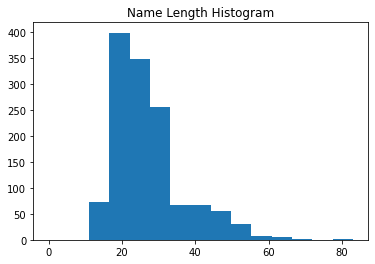

In [478]:
plt.hist([df['NameLength']], bins=15, range=(0,83))
plt.title('Name Length Histogram')

Text(0.5, 1.0, 'Survival distribution by NameLength')

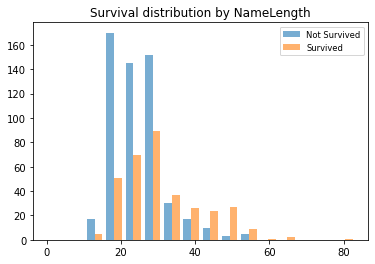

In [479]:
grouped = df.groupby(['Survived'])
group0 = grouped.get_group(0)
group1 = grouped.get_group(1)
plt.hist([group0.NameLength, group1.NameLength], bins=16, range=(0,83), stacked=False, 
        label=['Not Survived', 'Survived'], alpha=0.6)
plt.legend(loc='best', fontsize='small')
plt.title('Survival distribution by NameLength')

This shows names with longer lengths tended to survive. This information might be encoded in their class, so it's questionable if this feature will give any added information.

Let's look at family size, which is the sum of siblings, spouses, parents, and children of a person:

In [480]:
df['FamilySize'] = df['SibSp'] + df['Parch']

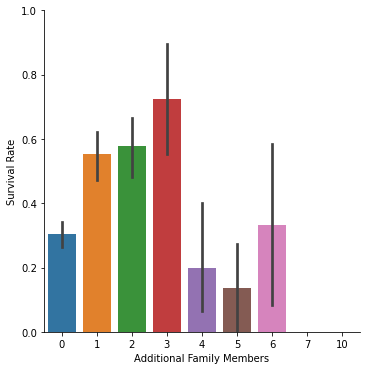

In [481]:
g = sns.catplot(x="FamilySize", y="Survived", data=df[df.Survived.notnull()], kind="bar")
g.set_axis_labels("Additional Family Members", "Survival Rate").set(ylim=(0, 1))

The above plot shows having 1-3 additional family members was best for one's chance of survival.

We'll make a feature, `FamilySizeCat`, that encodes this.

In [482]:
df['FamilySize'].describe()

count    1309.000
mean        0.884
std         1.584
min         0.000
25%         0.000
50%         0.000
75%         1.000
max        10.000
Name: FamilySize, dtype: float64

In [483]:
familysizemap = {0: 1, 1: 2, 2: 2, 3: 2, 4: 0, 5: 0, 6:0, 7:0, 8:0, 9:0, 10:0}
familysizeLabels = {'Large Family', 'Alone', 'Small Family'}
df['FamilySizeCat'] = df['FamilySize'].map(familysizemap)

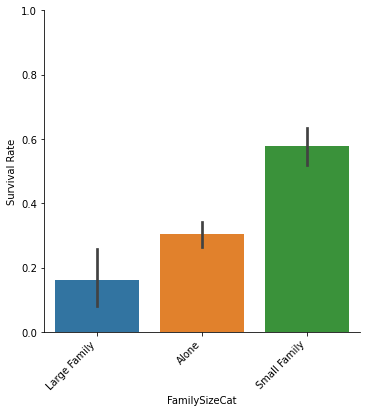

In [484]:
g = sns.catplot(x="FamilySizeCat", y="Survived", data=df[df.Survived.notnull()], kind="bar")
g.set_axis_labels("FamilySizeCat", "Survival Rate").set(ylim=(0, 1))
g.set_xticklabels(familysizeLabels, rotation=45, horizontalalignment='right')

We're finally done cleaning the data and doing our initial data exploration.

#### Step 3. Model setup

##### 3.1: Initial model creation

We'll drop the columns we don't need anymore, and make our training and test sets with the data that's been cleaned.

In [485]:
from sklearn.preprocessing import StandardScaler

drop_columns = ['PassengerId', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'NameFixed', 'Title', 'Deck', 'FamilySize']
X_trainFull = df.drop(drop_columns, axis=1).iloc[:train_size]
X_trainx = df.drop(drop_columns + ['Survived'], axis=1).iloc[:train_size]
X_train = StandardScaler().fit_transform(X_trainx)
y_train = df['Survived'].iloc[:train_size]
X_testx  = df.drop(drop_columns + ['Survived'], axis=1).iloc[train_size:]
X_test = StandardScaler().fit_transform(X_testx)

Check our data has the columns we want, and the data is not null and in numeric fields:

In [486]:
X_trainx.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Pclass         891 non-null    int64  
 1   Age            891 non-null    float64
 2   SibSp          891 non-null    int64  
 3   Parch          891 non-null    int64  
 4   Fare           891 non-null    float64
 5   Female         891 non-null    int32  
 6   TitleCat       891 non-null    int64  
 7   EmbarkedCat    891 non-null    int64  
 8   DeckCat        891 non-null    int64  
 9   NameLength     891 non-null    int64  
 10  FamilySizeCat  891 non-null    int64  
dtypes: float64(2), int32(1), int64(8)
memory usage: 80.1 KB


Check the ranges of the data:

In [487]:
X_trainx.describe()

,Pclass,Age,SibSp,Parch,Fare,Female,TitleCat,EmbarkedCat,DeckCat,NameLength,FamilySizeCat
count,891.000,891.000,891.000,891.000,891.000,891.000,891.000,891.000,891.000,891.000,891.000
mean,2.309,29.312,0.523,0.382,32.204,0.352,2.713,0.468,2.020,26.965,1.258
std,0.836,13.244,1.103,0.806,49.693,0.478,2.111,0.795,2.063,9.282,0.575
min,1.000,0.420,0.000,0.000,0.000,0.000,1.000,0.000,0.000,12.000,0.000
25%,2.000,22.000,0.000,0.000,7.910,0.000,1.000,0.000,1.000,20.000,1.000
50%,3.000,29.000,0.000,0.000,14.454,0.000,1.000,0.000,1.000,25.000,1.000
75%,3.000,35.500,1.000,0.000,31.000,1.000,5.000,1.000,1.000,30.000,2.000
max,3.000,80.000,8.000,6.000,512.329,1.000,8.000,2.000,8.000,82.000,2.000


Inspect the data:

In [488]:
X_trainx.head()

,Pclass,Age,SibSp,Parch,Fare,Female,TitleCat,EmbarkedCat,DeckCat,NameLength,FamilySizeCat
0,3,22.0,1,0,7.250,0,1,0,1,23,2
1,1,38.0,1,0,71.283,1,6,2,4,51,2
2,3,26.0,0,0,7.925,1,5,0,1,22,1
3,1,35.0,1,0,53.100,1,6,0,4,44,2
4,3,35.0,0,0,8.050,0,1,0,1,24,1


Now that all the fields are numeric, check which fields are most correlated with survival:

<AxesSubplot:>

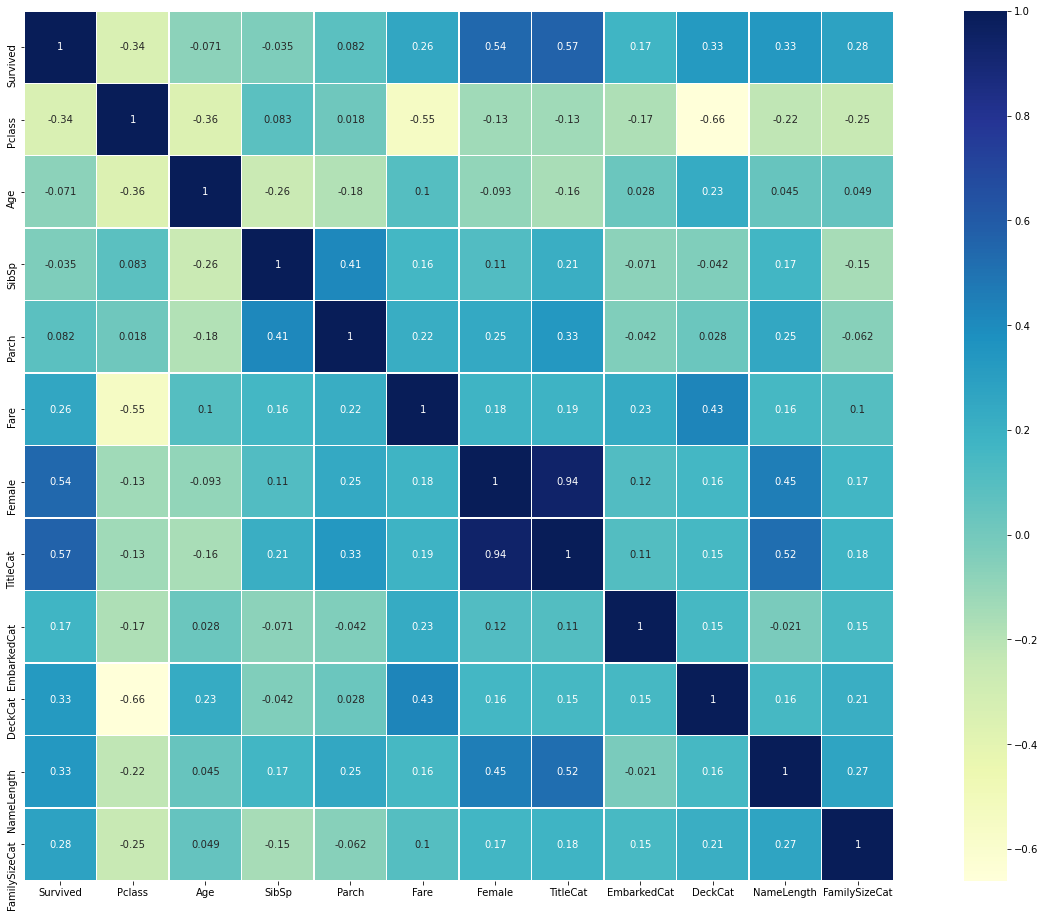

In [489]:
f, ax = plt.subplots(figsize = [25,16])
sns.heatmap(X_trainFull.corr(),linewidths = .5, annot = True, cmap = 'YlGnBu', square = True)

As expected, `TitleCat` and `Female` are most correlated with survival, and they are also very correlated to each other.

Now we'll make several classifiers using different models:

In [490]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier, plot_importance 

In [491]:
clf_rf = RandomForestClassifier()
clf_et = ExtraTreesClassifier()
clf_bc = BaggingClassifier()
clf_ada = AdaBoostClassifier()
clf_dt = DecisionTreeClassifier()
clf_xg = XGBClassifier()
clf_lr = LogisticRegression()
clf_svm = SVC()

In [492]:
Classifiers = ['RandomForest','ExtraTrees','Bagging','AdaBoost','DecisionTree','XGBoost','LogisticRegression','SVM']
scores = []
models = [clf_rf, clf_et, clf_bc, clf_ada, clf_dt, clf_xg, clf_lr, clf_svm]
for model in models:
    score = cross_val_score(model, X_train, y_train, scoring = 'accuracy', cv = 10, n_jobs = -1).mean()
    scores.append(score)

In [493]:
mode = pd.DataFrame(scores, index = Classifiers, columns = ['score']).sort_values(by = 'score',
             ascending = False)

With only their default hyperparameters, here are their accuracy scores using 10-fold cross-validation on the training set:

In [494]:
mode

,score
SVM,0.829
LogisticRegression,0.829
RandomForest,0.828
AdaBoost,0.818
ExtraTrees,0.816
XGBoost,0.813
Bagging,0.802
DecisionTree,0.766


##### 3.2: Hyperparameter optimization

Tuning hyperparameters is an extensive topic. In this notebook, we want to focus on diagnostics after the model has been set up, so here we won't dive into optimizing each classifier's hyperparameters. Instead, we'll use a grid search to test several hyperparameters for XGBoost, SVM, and Random Forest models:

In [495]:
parameters_xg = {'objective':['binary:logistic'], 'max_depth':[3,6,7], 'learning_rate': [0.1,0.2], 'n_estimators': [300,200], 
                 'min_child_weight': [4], 'reg_alpha': [6,0], 'reg_lambda': [1,8],'max_delta_step':[2],
                 'gamma':[0],'seed':[1],'use_label_encoder':[False],'eval_metric':['logloss']}

parameters_svm = {'C':[0.9,0.01],'kernel':['rbf','linear'], 'gamma':[0,0.1,'auto'], 'probability':[True,False],
                  'random_state':[0,7,16],'decision_function_shape':['ovo','ovr'],'degree':[3,4,10]}

parameters_rf = {'n_estimators': [100,50], 'max_features': [7,'auto',None],
                 'n_jobs': [-1], 'min_samples_leaf': [2,4,], 'random_state':[1,7,], 
                 'min_samples_split':[2,6,], 'oob_score': [True,False],
                 'criterion': ['gini'], 'warm_start': [False]}

In [496]:
def grid(model,parameters):
    grid = GridSearchCV(estimator = model, param_grid = parameters, cv = 10, 
                        scoring = 'accuracy')
    grid.fit(X_train,y_train)
    return grid.best_score_, grid.best_estimator_.get_params()

In [497]:
def imp_features(model, model_name, params):
    Model = model(**params)
    Model.fit(X_train,y_train)
    names = X_trainx.columns
    feature = Model.feature_importances_
    important_features = pd.Series(data = feature, index = names,)
    important_features = important_features.sort_values(ascending = True)
    return important_features.plot(kind = 'barh', grid = False,title = model_name)

For XGBoost, we can see what it considers the most important classifiers, which are `TitleCat` and `Pclass`:

<AxesSubplot:title={'center':'XGBoostClassifier'}>

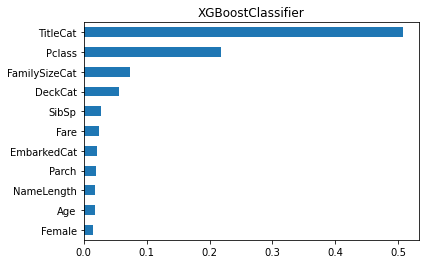

In [498]:
best_score_xg, best_params_xg = grid(clf_xg,parameters_xg)
imp_features(XGBClassifier, 'XGBoostClassifier', best_params_xg)

This makes sense, as TitleCat is basically a more refined feature of gender, and combined with class make an excellent predictor of survival.

Now XGBoost is doing much better in terms of accuracy:

In [499]:
print(best_score_xg)

0.8429213483146067


Let's tune the Random Forest model hyperparameters:

0.844019975031211


<AxesSubplot:title={'center':'Random Forest'}>

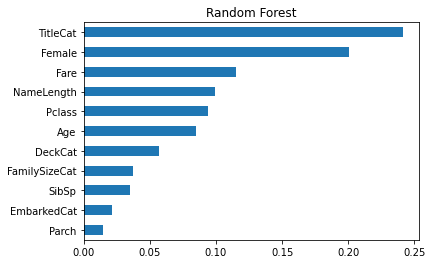

In [500]:
best_score_rf, best_params_rf = grid(clf_rf, parameters_rf)
print(best_score_rf)
imp_features(RandomForestClassifier,'Random Forest', best_params_rf)

The most important parameters for our Random Forest is `TitleCat` (same as XGBoost), and `Female`. Its accuracy 
score is now better as well at over 84%.

Let's also tune the Support Vector Machine:

In [501]:
best_score_svm, best_params_svm = grid(clf_svm, parameters_svm)
print(best_score_svm)

0.8294132334581773


In [502]:
clf_rf_best = RandomForestClassifier(**best_params_rf)
clf_xg_best = XGBClassifier(**best_params_xg)
clf_svm_best = SVC(**best_params_svm)

##### 3.3: Ensemble Classifier built upon previous classifiers

We'll also make an ensemble classifier, that does majority voting based on our tuned XGBoost, Random Forest, and SVM models:

In [503]:
from sklearn.ensemble import VotingClassifier

clf_e = VotingClassifier(estimators=[('xg', clf_xg_best), ('rf', clf_rf_best), ('svm', clf_svm_best)], voting='hard')

In [504]:
best_scores = []
best_models = [clf_rf_best, clf_et, clf_bc, clf_ada, clf_dt, clf_xg_best, clf_lr, clf_svm_best, clf_e]
for model in best_models:
    score = cross_val_score(model, X_train, y_train, scoring = 'accuracy', cv = 10, n_jobs = -1).mean()
    best_scores.append(score)

In [505]:
NewClassifiers = ['RandomForest','ExtraTrees','Bagging','AdaBoost','DecisionTree','XGBoost','LogisticRegression','SVM','Ensemble']
mode = pd.DataFrame(best_scores, index = NewClassifiers, columns = ['score']).sort_values(by = 'score',
             ascending = False)

Here's the accuracy scores now for our models:

In [506]:
mode


,score
RandomForest,0.844
XGBoost,0.843
Ensemble,0.843
SVM,0.829
LogisticRegression,0.829
ExtraTrees,0.822
AdaBoost,0.818
Bagging,0.811
DecisionTree,0.771


##### 3.4: ROC AUC scoring

We'll now look at ROC AUC scoring for all our models:

In [507]:
best_scores = []
best_models = [clf_rf_best, clf_et, clf_bc, clf_ada, clf_dt, clf_xg_best, clf_lr, clf_svm_best]
for model in best_models:
    score = cross_val_score(model, X_train, y_train, scoring = 'roc_auc', cv = 10, n_jobs = -1).mean()
    best_scores.append(score)
mode = pd.DataFrame(best_scores, index = Classifiers, columns = ['score']).sort_values(by = 'score',
             ascending = False)
mode

,score
RandomForest,0.877
SVM,0.874
LogisticRegression,0.873
XGBoost,0.873
Bagging,0.858
ExtraTrees,0.853
AdaBoost,0.850
DecisionTree,0.755


##### 3.5: Submitting predictions to Kaggle to obtain test set results

Submitting predictions from our top models to [Kaggle](https://www.kaggle.com/c/titanic/submit) for the test set yielded Random Forest giving our top score at 79.186% accuracy when first run:

In [508]:
#clf_e.fit(X_train, y_train)
#clf_xg_best.fit(X_train, y_train)
#clf_rf_best.fit(X_train, y_train)
#clf_svm_best.fit(X_train, y_train)
clf_lr.fit(X_train, y_train)


#preds = clf_e.predict(X_test).astype(int) # 0.78468
#preds = clf_xg_best.predict(X_test).astype(int) #0.77033
#preds = clf_rf_best.predict(X_test).astype(int) # 0.79186
#preds = clf_svm_best.predict(X_test).astype(int) #0.77272
preds = clf_lr.predict(X_test).astype(int) # 0.77511

predictions = pd.DataFrame()
predictions['PassengerId'] = test['PassengerId']
predictions['Survived'] = preds
predictions.set_index('PassengerId', inplace=True, drop=True)
predictions.to_csv('lr_jup2.csv')
print("Done")

Done


##### 3.6: Confusion Matrices and ROC Curves

Let's evaluate the confusion matrix and ROC Curve of these models.
In a typical machine learning problem where we don't want to evaluate the test set while improving our model, one approach is to create a development test set out of the training set. From the 891 passengers in the training set, where we have their survival data, we'll split this 75% into a reduced training set, and 25% into a development test set. In this development test set, we have the survival data. It is noted that we have trained our hyperparameters for our models on the development test set data already.

Set up development test set and train our top four models:

In [509]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

# Set up new training set and test set for ROC curve analysis
roc_X_train, roc_X_test, roc_y_train, roc_y_test = train_test_split(X_train, y_train, test_size=.25, random_state=42)

# Re-train models on the new training set
clf_rf_roc = RandomForestClassifier(**best_params_rf)
clf_rf_roc.fit(roc_X_train, roc_y_train)
clf_xg_roc = XGBClassifier(**best_params_xg)
clf_xg_roc.fit(roc_X_train, roc_y_train)
clf_svm_roc = SVC(**best_params_svm)
clf_svm_roc.fit(roc_X_train, roc_y_train)
clf_lr_roc = LogisticRegression()
clf_lr_roc.fit(roc_X_train, roc_y_train)

LogisticRegression()

In [510]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

best_models = [clf_rf_roc, clf_svm_roc, clf_lr_roc, clf_xg_roc]
model_names = ['Random Forest', 'SVM', 'Linear Regression', 'XGBoost']

conf = []
for model in best_models:
    conf.append(confusion_matrix(roc_y_test, model.predict(roc_X_test)))

Here's the confusion matrices for our classifiers. The True value is found on the y-axis, and the Predicted value is found on the x-axis.

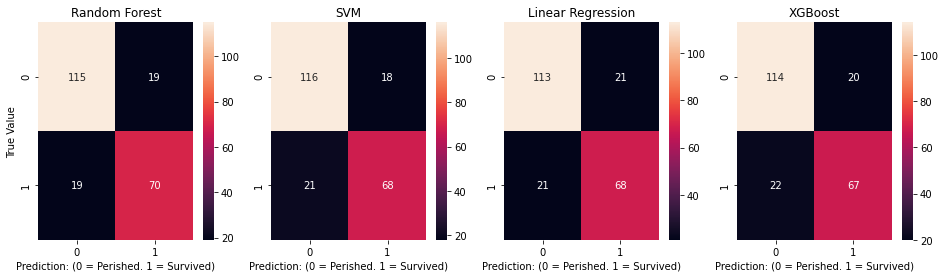

In [511]:
i = 0
fig = plt.figure(figsize=(16,4))
#fig, axs = plt.subplots(1,len(best_models))
for model in best_models:
    plt.subplot(1, len(best_models), i+1)
    sns.heatmap(conf[i], annot = True, fmt='d')
    plt.title(model_names[i])
    plt.xlabel("Prediction: (0 = Perished. 1 = Survived)")
    if i==0:
        plt.ylabel('True Value')    
    i += 1

This shows:
* True positives in bottom right
* True negatives in top left
* False positives in top right
* False negatives in bottom left

We see all models performed quite similarly, with Random Forest having the most true positives.

Here are scores for precision, sensitivity, specificity, as well as the F1 score.

In [512]:
conf_scores = []
for c in conf:
    precision   = c[1,1] / sum(c[:,1])
    recall      = c[1,1] / sum(c[1,:])
    specificity = c[0,0] / sum(c[0,:])
    f1_score    = 2*precision*recall / (precision + recall)
    conf_scores.append([precision, recall, specificity, f1_score])

conf_score_names = ["Precision", "Sensitivity", "Specificity", "F1"]  
pd.options.display.precision = 3
print(pd.DataFrame(conf_scores, model_names, conf_score_names))

                   Precision  Sensitivity  Specificity     F1
Random Forest          0.787        0.787        0.858  0.787
SVM                    0.791        0.764        0.866  0.777
Linear Regression      0.764        0.764        0.843  0.764
XGBoost                0.770        0.753        0.851  0.761


Here are the ROC Curves and AUC scores for the top 4 models:

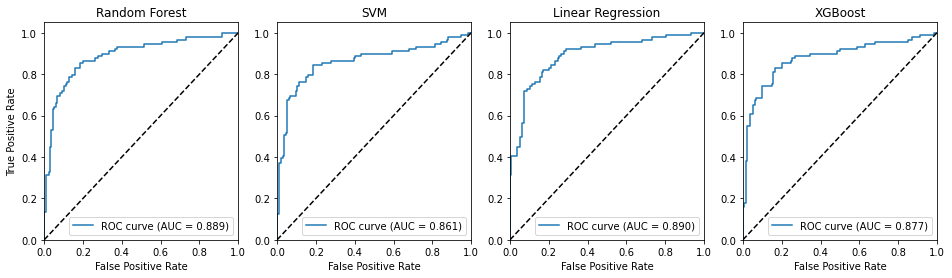

In [513]:
i = 0
fig = plt.figure(figsize=(16,4))
#fig, axs = plt.subplots(1,len(best_models))
for model in best_models:
    plt.subplot(1, len(best_models), i+1)
    # Determine the false positive and true positive rates
    fpr, tpr, thresholds = roc_curve(roc_y_test, model.predict_proba(roc_X_test)[:,1])
    # Calculate the AUC
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='ROC curve (AUC = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    if i==0:
        plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.title(model_names[i])
    i += 1

All have similar areas under the curve. The Random Forest classifier is smoother than XGBoost and SVM in the area when the False Positive Rate is around 10%. The Linear Regression model by the slimmest of margins has the highest area under the curve (AUC). If True Positive Rate or False Positive Rate need to be at certain levels, these graphs can help select the model and the threshold of the classifier to use.

#### Step 4. Diagnostics on Bias and Variance

In order to check whether our classifiers are suffering from high bias or variance, we'll see how increasing the number of training examples changes the accuracy of the models. This is the diagnostic taught by Professor Ng in CS 229 [Lecture 13](https://www.youtube.com/watch?v=ORrStCArmP4). The theory is that if the gap between training accuracy and test accuracy remains high as we add more training examples, then the problem with the model is likely overfitting (high variance). If the gap between training and test accuracy is small, and the accuracies plateau at a certain number of training examples, and these accuracies aren't at the desired performance, then the problem is likely high bias.

In [514]:
def model_pred(model, s):
    model.fit(roc_X_train[0:s], roc_y_train[0:s])
    modelpredtest = model.predict(roc_X_test)
    modelpredtraining = model.predict(roc_X_train[0:s])
    return accuracy_score(roc_y_test, modelpredtest), accuracy_score(roc_y_train[0:s], modelpredtraining)

In [515]:
max_restricted_training_size = len(roc_X_train)
x = np.arange(2,max_restricted_training_size, 20)
accuracy_training = []
accuracy_test = []
best_models = [clf_rf_roc, clf_svm_roc, clf_lr_roc, clf_xg_roc]
model_names = ['Random Forest', 'SVM', 'Linear Regression', 'XGBoost']

for model in best_models:
    y1 = np.zeros(x.shape)
    y2 = np.zeros(x.shape)
    j = 0
    for i in x:
        y1[j], y2[j] = model_pred(model, i)
        j += 1
    accuracy_test.append(y1)
    accuracy_training.append(y2)

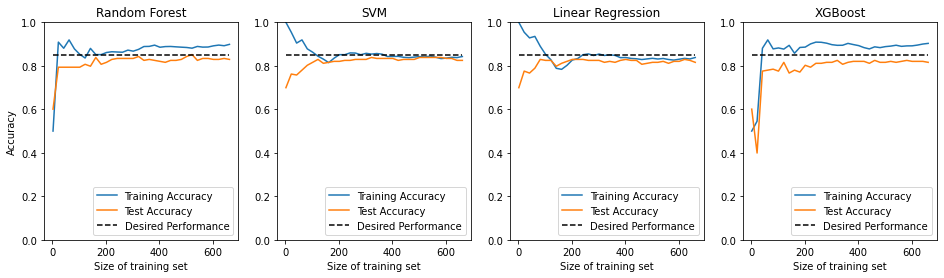

In [516]:
i = 0
fig = plt.figure(figsize=(16,4))
#fig, axs = plt.subplots(1,len(best_models))
for model in best_models:
    plt.subplot(1, len(best_models), i+1)
    plt.plot(x, accuracy_training[i])
    plt.plot(x, accuracy_test[i])
    plt.plot(x, np.array([0.85 for j in range(len(x))]), 'k--')
    plt.ylim([0.0, 1.0])
    plt.xlabel('Size of training set')
    if i==0:
        plt.ylabel('Accuracy')
    plt.title(model_names[i])
    plt.legend(['Training Accuracy', 'Test Accuracy', 'Desired Performance'], loc="lower right")
    i += 1


For the Random Forest and XGBoost classifiers, there is a large gap in the training error and test error, which is indicative of high variance. This makes sense as these algorithms are prone to overfitting, and we haven't done much work on the hyperparameters of these classifiers to combat this. So for the Random Forest and XGBoost classifiers, working on the hyperparameters to reduce variance is indicated.

For SVM and Linear Regression, we see the training and test accuracy relatively flat after 200 training examples, and lower than our desired test accuracy. This is indicative of high bias. That is, even with more data, it doesn't seem like the models will improve. In general, more training data does not seem to be helping these algorithms after 200-300 data points, so focusing on reducing bias looks to be indicated. This would look to add more features, and get more information out of the data.

For example, we could do more feature engineering to add features such as:
* Mother - Female with a child on board
* Child - Under 18 with a mother on board

We could also have a separate model to predict age, as many passengers had missing age information, and we initially just based a person's age on their title. This is not very accurate and led many people to have the same assumed age (especially men with title "Mr." which all received the same estimate of their age if it was missing).

One other approach is to add features that rely on knowledge of the survival of people in the training set. For example, if we know from the training set that a mother survives, then it is likely the mother's children survived. If we know someone in a family survives, then it's more likely other family members survived.

Another approach to reduce bias is to manually inspect the false positives and false negatives of a model to see if there is some piece of information that isn't accurately given in our features that could help the model predict the correct outcome. Better features could arise from such an analysis.


#### Step 5: Error Analysis
Another diagnostic to perform is error analysis. Let's take the important features in the Random Forest model and iteratively remove the least important feature to see how this affects prediction accuracy.

<AxesSubplot:title={'center':'Random Forest'}>

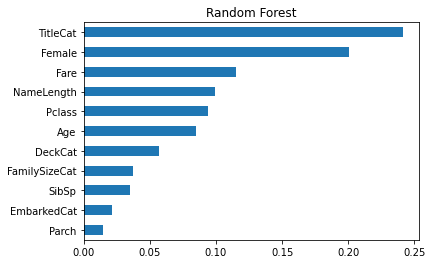

In [517]:
imp_features(RandomForestClassifier,'Random Forest', best_params_rf)

In [518]:
drop_order = ['Parch', 'EmbarkedCat', 'SibSp', 'FamilySizeCat', 'DeckCat', 'Age', 'Pclass', 'NameLength', 'Fare', 'Female']

accuracies = []

def dropandreport(i):
    X_trainx_reduced = X_trainx.drop(drop_order[0:i], axis=1)
    X_train_reduced = StandardScaler().fit_transform(X_trainx_reduced)
    roc_X_train_reduced, roc_X_test_reduced, roc_y_train_reduced, roc_y_test_reduced = train_test_split(X_train_reduced, y_train, test_size=.25, random_state=42)
    clf_rf_roc_reduced = RandomForestClassifier(**best_params_rf)
    clf_rf_roc_reduced.fit(roc_X_train_reduced, roc_y_train_reduced)
    roc_pred_reduced = clf_rf_roc_reduced.predict(roc_X_test_reduced)
    accuracy_score_reduced = accuracy_score(roc_y_test_reduced, roc_pred_reduced)
    accuracies.append(accuracy_score_reduced)

# Accuracy will all features
dropandreport(0)
# Drop features iteratively and see how accuracy changes
for i in range(len(drop_order)):
    dropandreport(i+1)

In the graph below, the first bar is the accuracy with all features (Full Data). Subsequent bars show the accuracy of the Random Forest model after the feature in the bar has been removed.

Text(0.5, 1.0, 'Error Analysis: Accuracy as we remove features one by one in a Random Forest model')

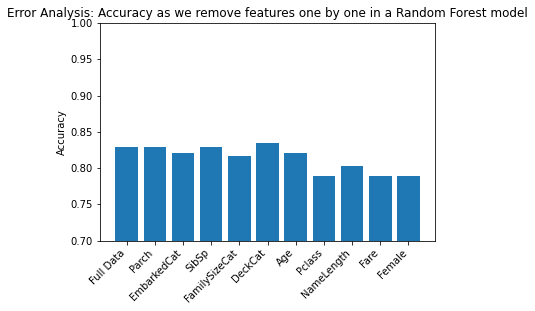

In [519]:
x_pos = [i for i, _ in enumerate(["Full Data"] + drop_order)]
#plt.bar(x_pos, accuracies)
plt.bar(["Full Data"] + drop_order, accuracies)
plt.ylim([0.7, 1.0])
plt.xticks(x_pos, ["Full Data"] + drop_order)
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.ylabel('Accuracy')
plt.title("Error Analysis: Accuracy as we remove features one by one in a Random Forest model")

Accuracy rose after the following were dropped:
    <ul>
    <li>SibSp</li>
    <li>DeckCat</li>
    <li>NameLength</li>
    </ul>
This suggests these features may not be so important.

Accuracy fell the most when `Pclass` was dropped, suggesting it has a lot of predictive value, which in our exploration of data was indeed the case. The most used feature was `TitleCat` which takes into account gender. Combined, gender and class seem to be the most useful.

#### Conclusions

The above notebook describes how to perform an analysis on models using a confusion matrix and ROC curves, in the event that the True Positive Rate and False Positive Rate are of interest.

We also covered performing diagnostics on models to see if the model suffers from high bias or high variance, by varying the number of training examples used and quantifying training set and test set accuracy. As well, we performed ablative analysis on our features to understand which features are important for our models and which may be just leading to overfitting.

In this challenge, gender and class look to be the primary sources of information that differentiate those that survived and those that perished on the Titanic. Extracting useful information from the other fields in the data set, without overfitting the data looks to be the primary challenge in improving predictions.

This notebook did not cover extensive work on optimizing hyperparameters of our models, nor did it cover all models which could be used as binary classifiers, such as neural networks. However, with the diagnostics explained in this tutorial, it points the way into how to improve models to gain optimal accuracy of predictions.